In [1]:
# Install dependencies
!pip3 install -U spacy contractions beautifulsoup4 spacy-cleaner pyspellchecker requests pandas scikit-learn tqdm matplotlib seaborn keras tensorflow
!python3 -m spacy download en_core_web_lg

  Using cached spacy-3.5.4-cp310-cp310-macosx_11_0_arm64.whl (6.6 MB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 MB 20.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 16.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 32.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 28.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 16.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
# Import statements
import re
from bs4 import BeautifulSoup
import contractions
from spellchecker import SpellChecker
import en_core_web_lg
import spacy
import requests
from tqdm.contrib.concurrent import process_map

import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB
from keras.utils import to_categorical
from keras import models
from keras import layers

In [3]:
# Exploratory data analysis
imdb_data = pd.read_csv('input/imdb_dataset.csv')
print(imdb_data.head(10))
imdb_data.describe()

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
def get_slang_dict() -> dict:
    '''Method to retrieve a dictionary of slang phrases and its actual meanings
    
    Returns
        str: Tokenized text
    '''
    abbr_dict = {}
    def getAbbr(alpha, abbr_dict):
        res = requests.get('https://www.noslang.com/dictionary/'+alpha)
        soup = BeautifulSoup(res.text, 'html.parser')
        for abbr in soup.find_all('abbr'):
            full = abbr['title'].lower()
            abrv = abbr.find('dt').text[:-2]
            abbr_dict[abrv] = full
    abbr_list = []
    for char in range(97,123):
        abbr_list.append(chr(char))
    for i in abbr_list:
        getAbbr(i, abbr_dict)
    return abbr_dict

In [5]:
def normalize_review(review: str) -> str:
    '''Method to normalize (preprocess and lemmatize) a review into a tokenized list of words
    Steps:
        1. HTML decoding
        2. Lowercase conversion
        3. Contractions expansion
        4. Entities detection
        5. Digits and punctuations removal
        5. Slang correction
        6. Spelling correction
        7. Word tokenization
        8. Stop words removal and removal of insignificant words (less than 2 characters)
        9. Lemmatization
    
    Required Args
        review (str): Text to be preprocessed
    
    Returns
        str: Tokenized text
    '''
    # HTML decoding
    review = BeautifulSoup(review).get_text()
    # Convert words to lowercase
    review = review.lower()
    # Expand contractions
    review_list = []
    for word in review.split():
        review_list.append(contractions.fix(word))
    review = ' '.join(review_list)
    # Make entities a single token eg. New York -> New-York
    nlp = en_core_web_lg.load()
    entity_list = []
    for ele in nlp(review).ents:
        if len(str(ele.text).split()) > 1:
            entity_list.append((ele.text, str(ele.text).replace(' ','_')))
    for item in entity_list:
        review = review.replace(item[0], item[1])
    # Digits and punctuations removal
    review_list = re.sub('[^a-zA-Z0-9_]', ' ', review).split()
    review_list = [word for word in review_list if not re.search(r'\d', word)]
    review = ' '.join(review_list)
    # Correct slang words / phrases
    global abbr_dict
    expanded = {}
    for word in review_list:
        if word in abbr_dict:
            expanded[word] = abbr_dict[word]
    for item in expanded:
        review = review.replace(item, expanded[item])
    # Correct spelling
    review_list = review.split()
    corrector = SpellChecker()
    misspelled = corrector.unknown(review_list)
    corrected = {}
    for word in misspelled:
        if corrector.correction(word):
            corrected[word] = corrector.correction(word)
    review = ' '.join(review_list)
    for item in corrected:
        review = review.replace(item, corrected[item])
    # Word tokenization, stop word removal and lemmatization
    doc = nlp(review)
    tokenized_word_list = []
    for token in doc:
        if '_' in token.text:
            tokenized_word_list.append(token.text)
        elif not token.is_stop and len(token.text) > 1:
            # Lemmatization
            tokenized_word_list.append(token.lemma_)
    return ' '.join(tokenized_word_list)

In [6]:
# Data preprocessing
abbr_dict = get_slang_dict()
imdb_data['review'] = imdb_data['review'].apply(normalize_review)
imdb_data = imdb_data[['review', 'sentiment']]

/var/folders/zw/_nztlx510ng_bk9rwth0cg280000gn/T/ipykernel_86298/1609383967.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review).get_text()


In [7]:
imdb_data.head(10)

,review,sentiment
0,reviewer mention watch episode hook right exac...,positive
1,wonderful little production film technique ii ...,positive
2,think thii wai wonderful way ipend time hot iu...,positive
3,basically family little boy jake think zombie ...,negative
4,petter_matter love time money ii viiually itun...,positive
5,probably time favorite movie itory ielfleiinei...,positive
6,iure like iee reiurrection date ihunt ieriei t...,positive
7,thii ihow wai amazing freih innovative idea fi...,negative
8,encourage poiitive commenti thii film wai look...,negative
9,like original gut wrench laughter like movie y...,positive


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

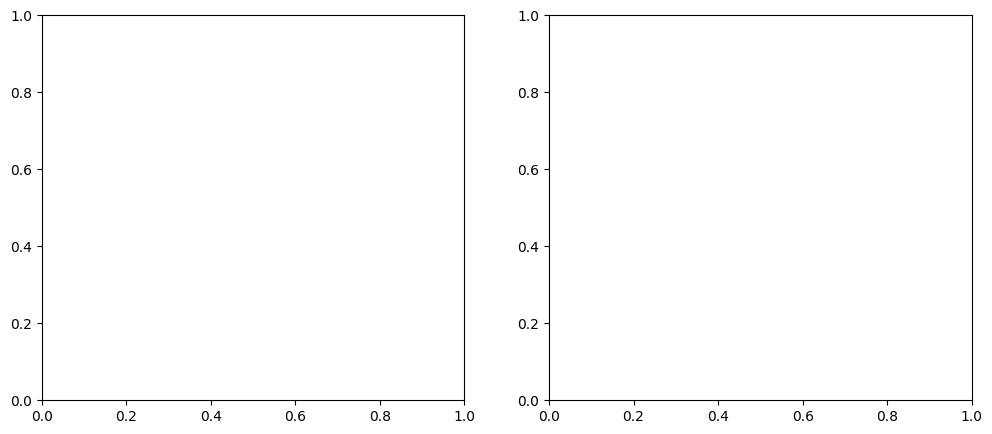

In [8]:
# Dataset splitting
sentiment_labels = imdb_data['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(imdb_data.review, sentiment_labels, test_size=0.2)

fig, ax = plt.subplots(1,2, figsize=(12,5))
for idx, group in enumerate([('Train', y_train), ('Test', y_test)]):
    data = group[1].value_counts()
    sns.barplot(ax=ax[idx], x=data.index, y=data.values)
    ax[idx].set_title(f'{group[0]} Label Count')
    ax[idx].set_xlabel(f'{group[0]} Labels')
    ax[idx].set_ylabel('Label Count')

plt.show()

In [ ]:
def bow(train: list, test: list) -> tuple[list, list]:
    '''Method to use the Bag of Words (BOW) method to calculate the occurrence of words within a document
    
    Required Args
        train (list): Training dataset of movie reviews
        test (list): Testing dataset of movie reviews
    
    Returns
        list: Transformed training dataset reviews
        list: Transformed Testing dataset reviews
    '''
    # Initialize vectorizer
    cv=CountVectorizer()
    # Transform training dataset
    transformed_train=cv.fit_transform(train)
    # Transform testing dataset
    transformed_test=cv.transform(test)
    return transformed_train, transformed_test

In [ ]:
# BOW Vectorization
bow_transformed_train, bow_transformed_test = bow(x_train, x_test)
print('BOW Train: ', bow_transformed_train.shape)
print('BOW Test: ', bow_transformed_test.shape)

In [ ]:
def tfidf(train: list, test: list) -> tuple[list, list]:
    '''Method to use the Term Frequency Inverse Document Frequency (TF-IDF) method to calculate how relevant a word in a series or corpus is to a text
    
    Required Args
        train (list): Training dataset of movie reviews
        test (list): Testing dataset of movie reviews
    
    Returns
        list: Transformed training dataset reviews
        list: Transformed Testing dataset reviews
    '''
    # Initialize vectorizer
    tfidf=TfidfVectorizer()
    # Transform training dataset
    transformed_train=tfidf.fit_transform(train)
    # Transform testing dataset
    transformed_test=tfidf.transform(test)
    return transformed_train, transformed_test

In [ ]:
# TF-IDF Vectorization
tfidf_transformed_train, tfidf_transformed_test = tfidf(x_train, x_test)
print('TFIDF Train: ', tfidf_transformed_train.shape)
print('TFIDF Test: ', tfidf_transformed_test.shape)

In [ ]:
# BOW + Multinomial Naive Bayes Classifier
bow_nb_start = time.time()
bow_nb = MultinomialNB()
bow_nb.fit(bow_transformed_train, y_train)
bow_nb_end = time.time()
bow_nb_y_pred = bow_nb.predict(bow_transformed_test)
print(classification_report(y_test, bow_nb_y_pred))
print()
print('Spending time: ', bow_nb_end - bow_nb_start)
print()
bow_nb_cm = confusion_matrix(y_test, bow_nb_y_pred)
bow_nb_cm_display = ConfusionMatrixDisplay(confusion_matrix=bow_nb_cm, display_labels=[False, True])
bow_nb_cm_display.plot()
plt.show()

In [ ]:
# BOW + Neural Network
bow_nn_start = time.time()
bow_nn = models.Sequential()
# Input - Layer
bow_nn.add(layers.Dense(50, activation = "relu", input_shape=(10000, )))
# Hidden - Layers
bow_nn.add(layers.Dropout(0.3, noise_shape=None, seed=None))
bow_nn.add(layers.Dense(50, activation = "relu"))
bow_nn.add(layers.Dropout(0.2, noise_shape=None, seed=None))
bow_nn.add(layers.Dense(50, activation = "relu"))
# Output- Layer
bow_nn.add(layers.Dense(1, activation = "sigmoid"))
# Compilation
bow_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bow_nn.fit(bow_transformed_train, y_train)
bow_nn_end = time.time()
bow_nn_y_pred = bow_nn.predict(bow_transformed_test)
print(classification_report(y_test, bow_nn_y_pred))
print()
print('Spending time: ', bow_nn_end - bow_nn_start)
print()
bow_nn_cm = confusion_matrix(y_test, bow_nn_y_pred)
bow_nn_cm_display = ConfusionMatrixDisplay(confusion_matrix=bow_nn_cm, display_labels=[False, True])
bow_nn_cm_display.plot()
plt.show()

In [ ]:
# TF-IDF + Naive Bayes Classifier
tfidf_nb_start = time.time()
tfidf_nb = MultinomialNB()
tfidf_nb.fit(tfidf_transformed_train, y_train)
tfidf_nb_end = time.time()
tfidf_nb_y_pred = tfidf_nb.predict(tfidf_transformed_test)
print('===== TFIDF + Naive Bayes Classifier =====')
print(classification_report(y_test, tfidf_nb_y_pred))
print()
print('Spending time: ', tfidf_nb_start - tfidf_nb_end)
print()
tfidf_nb_cm = confusion_matrix(y_test, tfidf_nb_y_pred)
tfidf_nb_cm_display = ConfusionMatrixDisplay(confusion_matrix=tfidf_nb_cm, display_labels=[False, True])
tfidf_nb_cm_display.plot()
plt.show()

In [ ]:
# TF-IDF + Neural Network
tfidf_nn_start = time.time()
tfidf_nn = models.Sequential()
# Input - Layer
tfidf_nn.add(layers.Dense(50, activation = "relu", input_shape=(10000, )))
# Hidden - Layers
tfidf_nn.add(layers.Dropout(0.3, noise_shape=None, seed=None))
tfidf_nn.add(layers.Dense(50, activation = "relu"))
tfidf_nn.add(layers.Dropout(0.2, noise_shape=None, seed=None))
tfidf_nn.add(layers.Dense(50, activation = "relu"))
# Output- Layer
tfidf_nn.add(layers.Dense(1, activation = "sigmoid"))
# Compilation
tfidf_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tfidf_nn.fit(bow_transformed_train, y_train)
tfidf_nn_end = time.time()
tfidf_nn_y_pred = bow_nn.predict(bow_transformed_test)
print(classification_report(y_test, tfidf_nn_y_pred))
print()
print('Spending time: ', tfidf_nn_end - tfidf_nn_start)
print()
tfidf_nn_cm = confusion_matrix(y_test, tfidf_nn_y_pred)
tfidf_nn_cm_display = ConfusionMatrixDisplay(confusion_matrix=tfidf_nn_cm, display_labels=[False, True])
tfidf_nn_cm_display.plot()
plt.show()